In [4]:
import numpy as np

from sklearn.linear_model import LogisticRegression
# 多項式・交互作用特徴量の生成
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 訓練データの読み込み

In [5]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [6]:
# 性別を変換する（訓練データ）
gemder=pd.get_dummies(df_train.loc[:,['Gender']])
df_train['Female']=gemder.loc[:,['Gender_Female']]
df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Female,Male
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,0,1
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,0,1
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,0,1
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,0,1
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,1,0


In [7]:
sigma=df_train.std()
df_desc = df_train.describe()

## 評価データの読み込み

In [8]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [9]:
# 性別を変換する（評価データ）
gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
df_vat['Female']=gemder.loc[:,['Gender_Female']]
df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Female,Male
0,25,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006,0,1
1,26,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562,1,0
2,64,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579,0,1
3,65,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070,0,1
4,34,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078,1,0


## データ加工

#### 訓練データのデータ加工前処理

In [10]:
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures


In [11]:
x_tmp=df_train.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']]

In [12]:
col='T_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='D_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALP'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALT_GPT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='AST_GOT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

In [13]:
x_tmp.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,1.212683,0.461926,259.404120,25.565119,46.009185,7.032290,3.517458,1.144570
std,0.927980,0.785715,112.027572,36.870576,41.686726,0.840664,0.559942,0.227237
min,0.585961,0.034861,163.261838,3.924518,11.283497,4.858679,2.180884,0.627133
25%,0.781258,0.144889,213.991414,13.644658,21.239157,6.730612,3.139153,1.004466
50%,0.835591,0.194085,220.092503,16.638001,27.056026,6.915580,3.621339,1.205016
75%,1.196759,0.335447,229.455927,23.056081,56.461568,7.536151,3.712524,1.287880
max,7.314605,4.614812,688.367780,370.984154,327.287931,8.739000,5.016970,1.821496


In [14]:
x_tmp.shape

(850, 8)

In [15]:
# 説明変数（訓練データ）
x_train = np.array(x_tmp)
print(x_tmp.head())

# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])


      T_Bil     D_Bil         ALP    ALT_GPT     AST_GOT        TP       Alb  \
0  0.786886  0.150498  220.178691  13.467617   21.729246  6.815731  3.112276   
1  1.003987  0.195625  221.218413  51.033462   64.752323  6.889608  3.051521   
2  0.657140  0.081287  320.770533  12.625011   30.613180  5.947767  2.489167   
3  0.906822  0.214173  369.278160  34.347597   54.510085  6.967183  3.613837   
4  1.734959  0.197706  222.782025  20.572891  170.010177  5.837537  3.068697   

   AG_ratio  
0  1.006802  
1  0.751346  
2  0.774952  
3  0.988155  
4  1.026654  


In [16]:
# 説明変数（評価データ）
x_tmp=df_vat.loc[:,['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']]

In [17]:
col='T_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

col='D_Bil'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALP'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='ALT_GPT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat


col='AST_GOT'
std=sigma[col]*3
vat=df_desc.loc['75%',col]*3
#x_tmp.loc[x_tmp[col]>(std),col]=std
x_tmp.loc[x_tmp[col]>(std),col]=vat

In [18]:
x_tmp.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,1.163750,0.425247,270.622807,25.951229,44.255609,7.089375,3.561579,1.154658
std,0.796683,0.763121,130.214897,41.253597,42.084924,0.877987,0.607376,0.248094
min,0.610073,0.053853,175.747532,7.862773,11.278741,4.970108,2.296308,0.668751
25%,0.787081,0.147714,214.211425,13.551174,20.842910,6.725417,3.128234,1.008996
50%,0.845039,0.193881,220.738618,16.449139,25.971274,6.931101,3.620933,1.216902
75%,0.973743,0.236440,231.839764,22.760056,52.746083,7.553500,3.738682,1.287962
max,6.822959,4.671090,688.367780,361.417106,284.304483,8.752045,5.009589,1.805157


In [19]:
x_tmp.shape

(350, 8)

In [20]:
print(x_tmp.head())
x_vat = np.array(x_tmp)

      T_Bil     D_Bil         ALP    ALT_GPT    AST_GOT        TP       Alb  \
0  0.801797  0.186800  214.448679  15.260516  19.496649  6.817903  3.600752   
1  0.834857  0.116426  234.136816  10.509159  16.733312  6.795433  3.111043   
2  0.791830  0.197940  216.039909  14.578304  20.695866  7.524030  3.627621   
3  0.834003  0.175741  200.901130  12.820356  20.102517  6.829109  3.626758   
4  0.690296  0.135503  208.705835  20.279018  25.096685  8.663530  4.170750   

   AG_ratio  
0  1.288006  
1  1.030562  
2  1.278579  
3  1.275070  
4  1.280078  


In [21]:
# 標準化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc = StandardScaler() 
#norm = MinMaxScaler()
x_train=sc.fit_transform(x_train)
x_vat=sc.transform(x_vat)

In [29]:
x=pd.DataFrame(x_train , columns=['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio'])
x.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,8.500000e+02,8.500000e+02,850.000000,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02,8.500000e+02
mean,2.591391e-16,8.986276e-17,0.000000,1.118060e-16,1.212102e-16,-5.642545e-16,8.359326e-17,4.806613e-17
std,1.000589e+00,1.000589e+00,1.000589,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00,1.000589e+00
min,-6.757592e-01,-5.438577e-01,-0.858707,-5.872797e-01,-8.335059e-01,-2.587111e+00,-2.388393e+00,-2.278419e+00
25%,-4.651810e-01,-4.037396e-01,-0.405609,-3.234959e-01,-5.945444e-01,-3.590678e-01,-6.760122e-01,-6.169154e-01
50%,-4.065968e-01,-3.410888e-01,-0.351117,-2.422629e-01,-4.549246e-01,-1.389130e-01,1.856302e-01,2.661620e-01
75%,-1.717003e-02,-1.610686e-01,-0.267486,-6.808995e-02,2.508841e-01,5.997134e-01,3.485734e-01,6.310362e-01
max,6.579359e+00,5.288599e+00,3.831344,9.373935e+00,6.751414e+00,2.031389e+00,2.679556e+00,2.980694e+00


## 訓練

In [22]:
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [23]:
# モデルの学習・予測
model = LogisticRegression()
model.fit(X_train, Y_train)

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

## 検証データを使って予測値の検証

In [24]:
# 検証 <-訓練データ 
model.score(X_train ,Y_train)

0.8367346938775511

In [25]:
# 検証 <-検証データ
# (検証データと値が近いなら信用できる。
#  どこまでの差異を近いとするかはそれぞれ
#  判断する必要がある。)
model.score(X_test,Y_test)

0.8544600938967136

## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

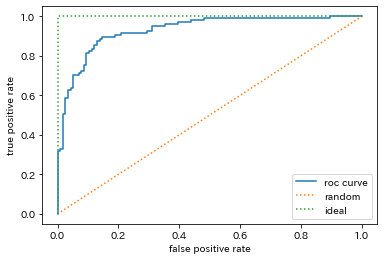

[2.         1.         0.96909724 0.96876824 0.96651864 0.96373752
 0.85951583 0.85280967 0.7641416  0.75495602 0.72170963 0.71143604
 0.70658855 0.68689509 0.65466327 0.64930167 0.62489842 0.60882635
 0.60866962 0.60548292 0.59256321 0.57301626 0.48405892 0.48291151
 0.45624893 0.45578785 0.42084423 0.40445691 0.3797378  0.36974361
 0.36697529 0.36545657 0.35813616 0.35690217 0.35228156 0.3100663
 0.3083089  0.28595719 0.27082045 0.24778426 0.24686443 0.24432868
 0.23478058 0.22158627 0.22145685 0.20143532 0.20100183 0.18144381
 0.18087546 0.17495603 0.17485705 0.10851846 0.10835855 0.03881129]


In [26]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=y_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [27]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=Y_test, y_score=y_pred)
print("AUC:", auc_score)

AUC: 0.9293458940632777


## 予測する

In [30]:
y_pred = model.predict_proba(x_vat)[:, 1]
y_pred=np.array(y_pred.round() ,dtype=np.int64)
df_out = pd.DataFrame(y_pred, columns=['val'])
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)

In [ ]:
#from collections import Counter
#print(Counter(y_predict))

## モデルの保存

In [ ]:
#import pickle
#with open('model.pickle', mode='wb') as fp:
#    pickle.dump(model, fp)